## Extracting Dihedral Angles at Triple Junctions from Segmentation Stacks

### Prep

In [13]:
### Imports

import itertools
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from ipywidgets import interact

from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate as sciint

In [14]:
### Load input

im = io.imread('../../Generated/three_intersecting_spheres_aniso.tif')
print(im.dtype, im.shape)

uint8 (200, 400, 400)


In [15]:
### Show input segmentations

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(im[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Object Outlines

In [16]:
### Identify outlines by comparing shifted images

# Pad the image by 1 voxel on all sides
im_pad = np.pad(im, 1, mode='reflect')

# Get possible shifts in all directions
shifts = itertools.product([0,1], repeat=3)

# Check and accumulate differences in shifts
outlines = np.zeros_like(im, dtype=np.bool)
for shift in shifts:
    zs0, ys0, xs0 = [slice(1, None) if s else slice(None) for s in shift]
    zs1, ys1, xs1 = [slice(None,-1) if s else slice(None) for s in shift]
    comparison = im_pad[zs0, ys0, xs0] != im_pad[zs1, ys1, xs1]
    outlines  += comparison[:im.shape[0],  :im.shape[1],  :im.shape[2]]
    outlines  += comparison[-im.shape[0]:, -im.shape[1]:, -im.shape[2]:]  # Symmetry
    
# Re-annotate the cell identities
outlines_id = outlines * im

# Report
print(outlines.dtype, outlines.shape)
print(outlines_id.dtype, outlines_id.shape)

bool (200, 400, 400)
uint8 (200, 400, 400)


In [17]:
### Show identified outlines

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Triple Edges and Triple Junctions

In [18]:
### Find coordinates of all voxels involved in triple junctions

# Get coordinates of all cell outline voxels
OCs = np.array(np.where(outlines)).T  # OCs <- "Outline Coordinates"

# Go through outline coordinates (oc) and find TEs
TEs = []  # TEs <- "Triple Edes"
for OC in OCs:
    selection = im_pad[OC[0]+1:OC[0]+3, OC[1]+1:OC[1]+3, OC[2]+1:OC[2]+3]
    if len(set(selection.flatten())) == 3:
        TEs.append(OC+0.5)
        
# Convert TE list to numpy array
TEs = np.array(TEs)

In [19]:
### Build a dict of TJs structured as: {tuple(cell1_ID, cell2_ID, cell3_ID) : array(TEs, Dimensions)}

# Prepare defaultdict
from collections import defaultdict
TJs = defaultdict(lambda : [[],[],[]])  # TJs <- "Triple Junctions"

# Go through TEs, create IDs, assign coordinates to IDs
for TE in TEs:
    selection = im_pad[np.int(TE[0])+1:np.int(TE[0])+3, 
                       np.int(TE[1])+1:np.int(TE[1])+3, 
                       np.int(TE[2])+1:np.int(TE[2])+3]
    TJ_ID = tuple(sorted(set(selection.flatten())))
    TJs[TJ_ID][0].append(TE[0])
    TJs[TJ_ID][1].append(TE[1])
    TJs[TJ_ID][2].append(TE[2])

# Convert TJ lists to numpy arrays
for key in TJs.keys():
    TJs[key] = np.array(TJs[key]).T

In [20]:
### Show identified TJs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each TJ...
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        
        # Get the TJs TEs in the selected z plane
        TEs_in_plane = TJs[TJ_ID][np.floor(TJs[TJ_ID][:,0])==z]
        
        # Plot the points (note the curios way of setting the color!)
        plt.scatter(TEs_in_plane[:, 2], TEs_in_plane[:, 1],
                    c=[TJ_num for _ in range(TEs_in_plane.shape[0])], 
                    cmap='hsv', vmin=0, vmax=len(TJs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

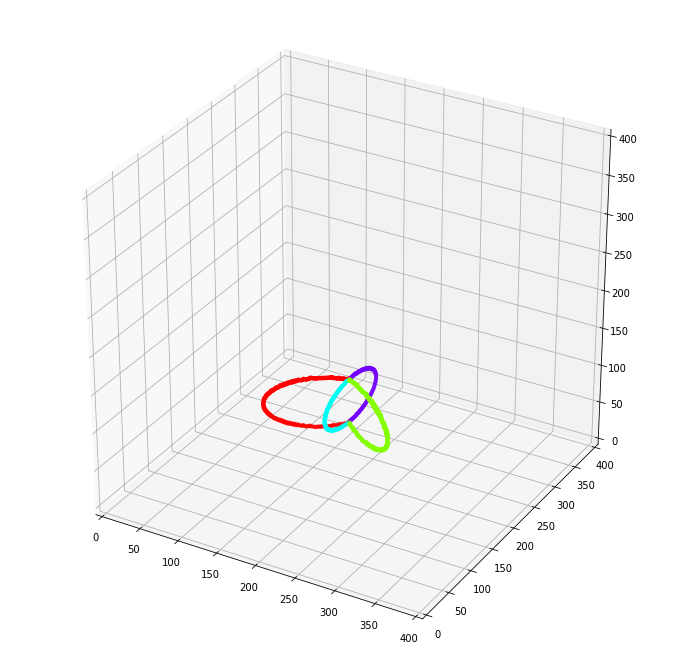

In [21]:
### Show identified TJs as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.scatter(TJs[TJ_ID][:,2], TJs[TJ_ID][:,1], TJs[TJ_ID][:,0],
               c=[TJ_num for _ in range(TJs[TJ_ID].shape[0])], 
               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

## Also show cell outlines [takes several seconds to render!]
#ax.scatter([c[2] for c in OCs],
#           [c[1] for c in OCs],
#           [c[0] for c in OCs],
#           c='gray', alpha=0.05, linewidth=0, s=5)

# Axis limits
ax.set_xlim([0,400])
ax.set_ylim([0,400])
ax.set_zlim([0,400])  # NOTE: RESULT IS SQUASHED IF RESOLUTION IS NOT CONSIDERED!

# Finish
plt.show()

### Next Up: Spline Fitting

In [33]:
tckDict={}
fpDict={}
ierDict={}
msgDict={}
for tjid in TJs.keys():
    
    
    

for tjid in TJs.keys():
    totalArray=[TJs[tjid][:,2],TJs[tjid][:,1],TJs[tjid][:,0]]
    tck,fp,ier,msg=spline=sciint.splprep(x=totalArray, k=2,quiet=0, full_output=1)
    tckDict[tjid]=tck
    fpDict[tjid]=fp
    ierDict[tjid]=ier
    msgDict[tjid]=msg
splevDict={}
tvals=np.linspace(0,1,9)
for x in tckDict.keys():
    y=sciint.splev(x=tvals, tck=tckDict[x][0])
    splevDict[x]=y







    
    


### TODO

- Brodland approach
    - Fit splines to outlines in the image plane
    - Identify angles in image plane for each TE *[sort of needed in both]*
    - Fit splines to TJs *[needed in both]*
    - Find normal plane to TJ-spline at each TE *[needed in both]*
    - Project image plane angles onto normal plane
    
    
- Better approach?
    - Fit splines to TJs *[needed in both]*
    - Find normal plane to TJ-spline at each TE *[needed in both]*
    - Identify angles in normal plane for each TE *[sort of needed in both]*